In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import boto3
from PIL import Image
from glob import glob
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [52]:
img_dir = glob("../Data/*")

In [53]:
img_dir = img_dir[2:]

In [54]:
img_dir

['../Data/MoetChandon_Champagne.png',
 '../Data/Casillero_del_Diablo.png',
 '../Data/Cinzano_Prosecco.png']

In [55]:
def view_image(img_list):
    fig = plt.figure(figsize=(40, 30))
    for i in range(len(img_list)):
        ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
        ax.imshow(img_list[i])
        ax.set_title(f"Label: {i}")

In [56]:
img_list = []
for i in range(3):
    img = cv2.imread(img_dir[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_list.append(img)

In [57]:
print(img_list[0].shape)

(960, 276, 3)


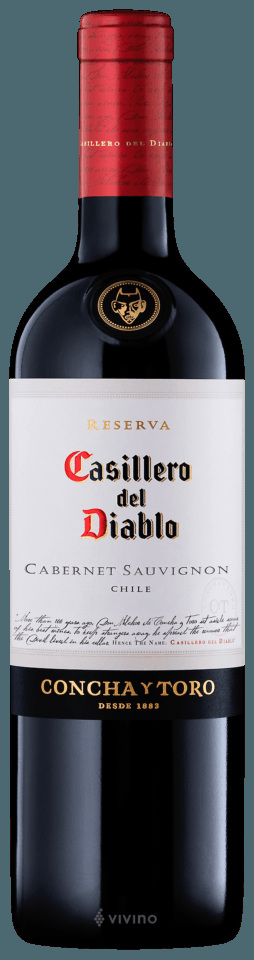

In [58]:
Image.fromarray(img_list[1])

In [59]:
"""
1. 사이즈 고정 0
2. 밝기 저-고 0
3. 화질 저-고
4. 회전 축에 따라 좌우 15~20도 까지 0
5. 
"""

# Compose transform_model
transform_model = A.Compose([
    A.Resize(height=960, width=260, always_apply=True),
    A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.3),
    A.Blur(blur_limit=8),
#     A.Rotate(limit=16, border_mode=1),
    A.SafeRotate(limit=16, border_mode=1),
    A.ToFloat(max_value=255, always_apply=True)
])

In [60]:
transformed_img_list = [ transform_model(image=img_list[i])["image"] for i in range(len(img_list)) ]

In [61]:
def get_transform_list(number_of_classes, origin_img_list, augmentation_model, total_count):
    list_for_return = []
    for idx in range(number_of_classes):
        list_for_return.append([augmentation_model(image=origin_img_list[idx])["image"] for _ in range(total_count) ])
    return list_for_return

In [62]:
transformed_list = get_transform_list(number_of_classes=3, origin_img_list=img_list, augmentation_model=transform_model, total_count=50)

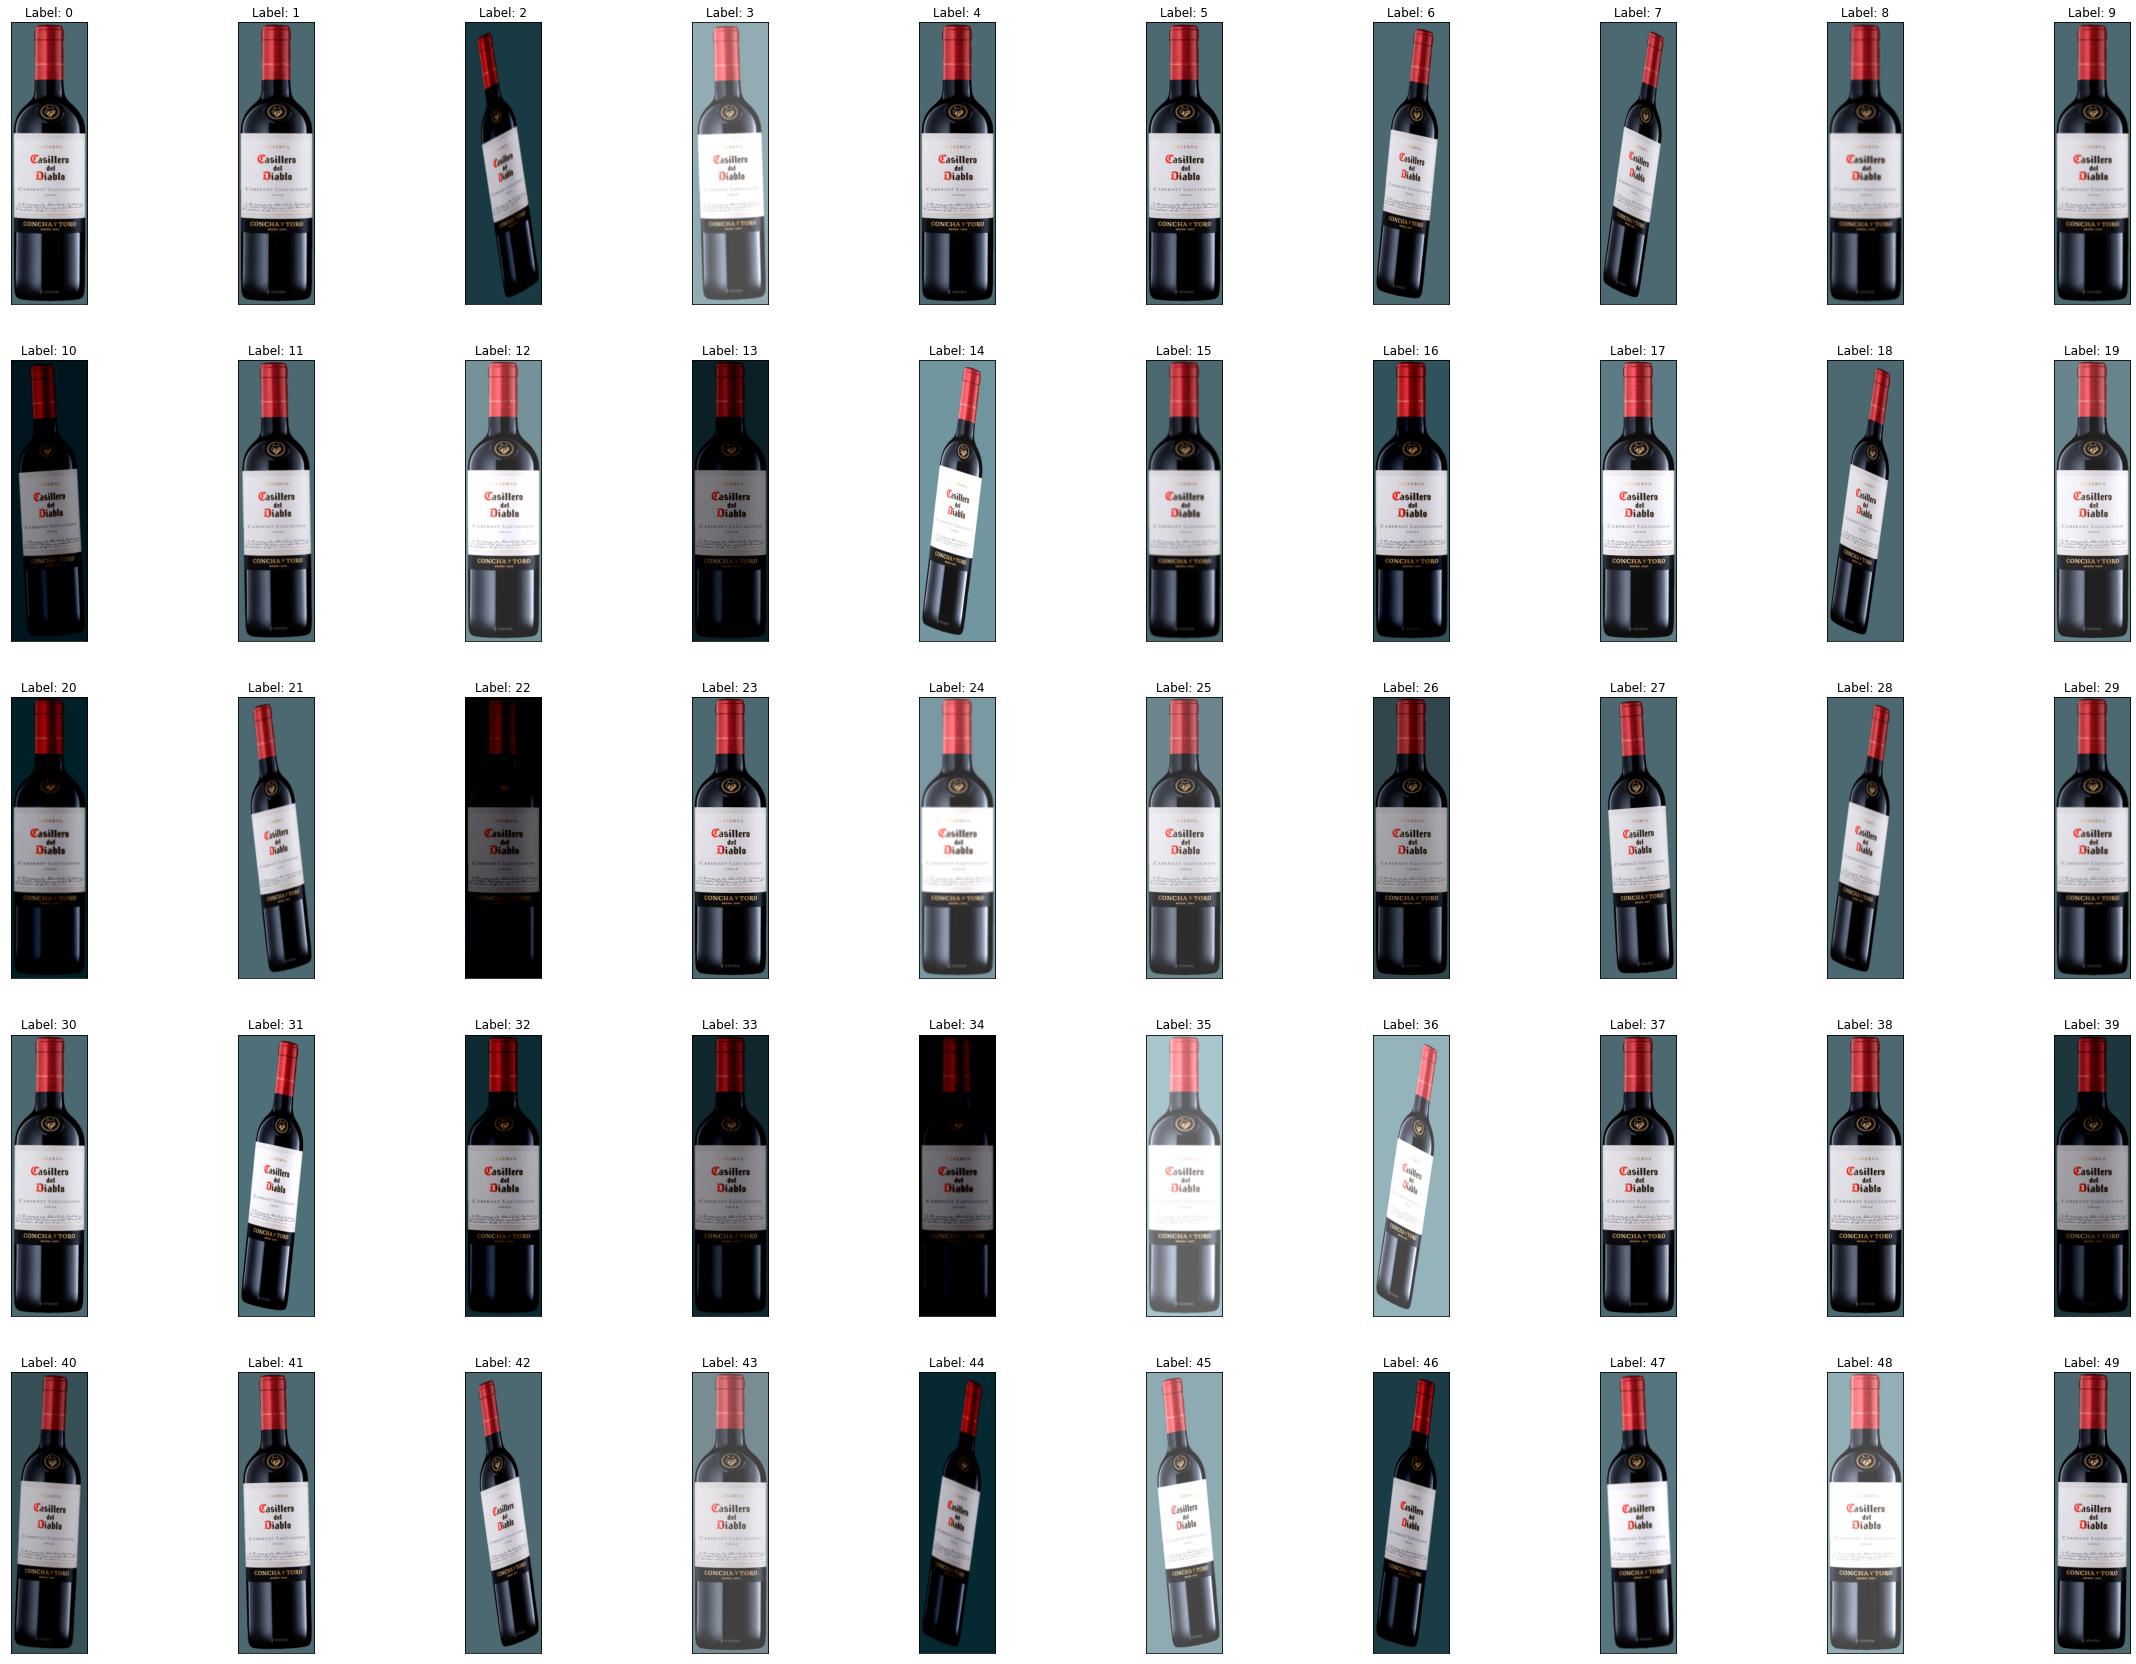

In [63]:
view_image(transformed_list[1])

In [64]:
#transformed_list 크기(3, 50, 960, 260, 3)
# 0:모엣샹동, 1:디아블로 , 2:친자노
x = []
y = []

for i in range(len(transformed_list)):
    for j in range(len(transformed_list[i])):
        x.append(np.array(transformed_list[i][j]))
        y.append(i)

x = np.array(x)
y = np.array(y)

In [65]:
print(x.shape, y.shape)

(150, 960, 260, 3) (150,)


In [66]:
from tensorflow.keras.utils import to_categorical

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [68]:
x_train = x.copy()
y_train = y.copy()

In [69]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [70]:
num_classes = len(img_list)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [71]:
y_test.shape

(15, 3)

In [72]:
# Modeling
base_model = Sequential()

base_model.add( MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(960, 260, 3)))



base_model.add(Flatten())
# 레이어 추가 + dropout 0.3~~5 오버피팅 걷어내기
base_model.add(Dense(num_classes, activation='softmax'))
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 30, 9, 1280)       2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1036803   
Total params: 3,294,787
Trainable params: 3,260,675
Non-trainable params: 34,112
_________________________________________________________________


In [73]:
y_test.shape

(15, 3)

In [74]:
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
base_model.fit(x_train, y_train, batch_size=10, epochs=15, verbose=1, validation_data=(x_test, y_test))

Epoch 1/15
15/15 [==============================] - 4s 267ms/step - loss: 0.3781 - accuracy: 0.9400 - val_loss: 10.1452 - val_accuracy: 0.7333
Epoch 2/15
15/15 [==============================] - 3s 207ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 20.5956 - val_accuracy: 0.7333
Epoch 3/15
15/15 [==============================] - 3s 204ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 22.7789 - val_accuracy: 0.7333
Epoch 4/15
15/15 [==============================] - 3s 208ms/step - loss: 2.9007e-07 - accuracy: 1.0000 - val_loss: 17.3463 - val_accuracy: 0.7333
Epoch 5/15
15/15 [==============================] - 3s 204ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 12.4576 - val_accuracy: 0.7333
Epoch 6/15
15/15 [==============================] - 3s 204ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 10.5975 - val_accuracy: 0.7333
Epoch 7/15
15/15 [==============================] - 3s 202ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.3946

In [76]:
score = base_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.799759864807129
Test accuracy: 0.8666666746139526


In [77]:
# wait

In [78]:
img_dir_for_test = glob("../Data/*")

In [79]:
img_dir_for_test

['../Data/test.jpg',
 '../Data/test_preprocess.jpg',
 '../Data/MoetChandon_Champagne.png',
 '../Data/Casillero_del_Diablo.png',
 '../Data/Cinzano_Prosecco.png']

In [89]:
img_dir_for_test[0]

'../Data/test.jpg'

In [90]:
test_img = cv2.imread(img_dir_for_test[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

In [91]:
test_transform = transform_model(image=test_img)["image"]

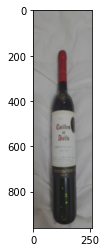

In [92]:
plt.imshow(test_transform)
test_transform = np.expand_dims(test_transform, axis=0)

In [93]:
result = base_model.predict(test_transform)

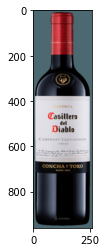

In [101]:
for i in range(len(result[0])):
    if max(result[0]) == result[0][i]:
        plt.imshow(transformed_list[i][0])

In [100]:
max(result[0])

0.5510519

In [98]:
result

array([[1.2754894e-30, 5.5105191e-01, 4.4894806e-01]], dtype=float32)

In [96]:
# base_model.save("beta_model.h5")

In [97]:
# re-load model